In [1]:
import preprocess as pp
import configs
import persister
import relation
import lda
import vis
import evaluate
from utils import *

from collections import Counter
from pprint import pprint
from functools import reduce

import re
import numpy as np
from nltk.tree import Tree
from nltk import word_tokenize,sent_tokenize

not use stanford CoreNLP client!


In [2]:
# is_news = 1

# l = 7
# t = 4
# m = "c_v"
# i = 200
# min_df = 1

is_news = 0
l = 6
t = 14
m = "c_v"
i = 200
min_df = 1

size = 100

# load
if is_news:
    _raw = persister.load_json(configs.RAWNEWS)
    parse = persister.read_parse()
    _input = persister.read_input(configs.NEWSINPUT)
    model_name = configs.NEWSMODEL.format(l, t, m, i, min_df)
    terms, doc_topic, topic_word = persister.read_lda(configs.NEWSLDA.format(model_name))
    model = persister.load_model(model_name)
    vec = persister.load_model(configs.NEWSVEC.format(min_df))
    w2vmodel = persister.load_wv(configs.NEWSWV.format(size))
    print("load news")
else:
    _raw = persister.load_json(configs.RAWABSTRACT)
    _input = persister.read_input(configs.ABSTRACTINPUT)
    model_name = configs.ABSTRACTMODEL.format(l, t, m, i, min_df)
    terms, doc_topic, topic_word = persister.read_lda(configs.ABSTRACTLDA.format(model_name))
    parse = persister.read_parse(configs.ABSTRACTPARSE)
    model = persister.load_model(model_name)
    vec = persister.load_model(configs.ABSVEC.format(min_df))
    w2vmodel = persister.load_wv(configs.ABSWV.format(size))
    print("load abs")
tf = vec.fit_transform(_input)
top_terms, top_docs = lda.get_topics(topic_word, terms, doc_topic,20)
word_values = []
for i in top_terms:
    tmp = []
    for j in i:
        tmp.append((terms[j[0]], j[1]))
#         tmp.append(terms[j[0]])
    word_values.append(tmp)
df_top_words, df_top_docs = lda.pd_topics_vis(word_values, top_docs)

load abs


In [3]:
len(terms)

9933

In [4]:
distr = lda.get_dominant_topic(doc_topic)
print("docs distribution:",dict(Counter(distr)))

docs distribution: {3: 395, 12: 766, 13: 5, 0: 27, 11: 83, 6: 1176, 4: 140, 7: 1, 1: 2, 10: 1}


In [5]:
print("top terms info:")
df_top_words

top terms info:


,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15,Word 16,Word 17,Word 18,Word 19
Topic 0,"(patient, 221.18)","(health, 156.45)","(disease, 154.5)","(medical, 143.69)","(clinical, 137.79)","(gene, 113.72)","(treatment, 106.83)","(datum, 94.07)","(diagnosis, 83.0)","(care, 68.83)","(study, 63.52)","(functional, 62.15)","(tourist, 57.71)","(record, 54.26)","(tourism, 54.06)","(function, 50.48)","(association, 48.94)","(conclusion, 46.28)","(result, 44.88)","(prediction, 44.08)"
Topic 1,"(news, 259.54)","(style, 86.19)","(divergence, 63.1)","(lm, 50.88)","(article, 37.19)","(list, 36.26)","(artifact, 27.07)","(software, 26.52)","(setting, 26.22)","(stop, 25.47)","(story, 25.25)","(kl, 22.62)","(kullback, 21.37)","(density, 21.02)","(combinatorial, 20.41)","(leibler, 20.37)","(client, 20.19)","(player, 18.96)","(idea, 16.53)","(headline, 16.33)"
Topic 2,"(child, 19.85)","(hyperspectral, 11.69)","(isoform, 9.79)","(homogenous, 7.93)","(tot, 7.11)","(parent, 7.01)","(negotiation, 6.85)","(lv, 6.78)","(movrec, 6.69)","(yor, 6.67)","(pitman, 6.67)","(geoclef, 6.22)","(lane, 5.93)","(ftm, 5.9)","(superpixel, 5.87)","(ldlm, 5.12)","(ldalr, 5.06)","(vertical, 5.03)","(blau, 4.99)","(cbe, 4.86)"
Topic 3,"(use, 774.45)","(datum, 691.96)","(topic, 635.56)","(event, 447.82)","(activity, 416.09)","(analysis, 402.85)","(time, 393.15)","(study, 386.16)","(identify, 340.06)","(latent, 334.16)","(social, 330.52)","(pattern, 316.37)","(allocation, 311.09)","(dirichlet, 293.64)","(approach, 289.6)","(analyze, 275.95)","(change, 271.08)","(software, 241.73)","(network, 237.56)","(community, 237.21)"
Topic 4,"(image, 910.26)","(feature, 421.58)","(object, 376.84)","(propose, 348.52)","(visual, 296.13)","(method, 295.57)","(video, 294.0)","(scene, 289.52)","(level, 214.63)","(human, 195.09)","(result, 176.11)","(use, 171.6)","(spatial, 170.43)","(annotation, 167.65)","(model, 167.43)","(recognition, 166.41)","(classification, 163.3)","(semantic, 151.41)","(latent, 142.66)","(region, 141.64)"
Topic 5,"(author, 92.33)","(song, 79.19)","(genre, 39.85)","(indexing, 37.56)","(write, 34.77)","(lsi, 27.65)","(pn, 27.24)","(digital, 23.5)","(oov, 20.37)","(indonesian, 19.81)","(lyric, 17.49)","(music, 16.78)","(musical, 16.56)","(abbreviation, 15.75)","(broadcast, 14.92)","(commonness, 14.53)","(writer, 13.97)","(intrinsic, 13.41)","(authorship, 13.14)","(forensic, 12.59)"
Topic 6,"(model, 4572.2)","(topic, 3802.4)","(latent, 1869.53)","(document, 1816.82)","(use, 1707.65)","(lda, 1596.94)","(method, 1559.28)","(word, 1384.37)","(dirichlet, 1360.57)","(propose, 1312.33)","(allocation, 1144.06)","(text, 1130.34)","(datum, 1093.51)","(algorithm, 958.69)","(result, 891.73)","(approach, 873.17)","(base, 804.38)","(paper, 791.13)","(feature, 742.09)","(distribution, 661.89)"
Topic 7,"(question, 166.56)","(sleep, 24.96)","(recipient, 21.27)","(complaint, 19.62)","(thread, 18.53)","(answerer, 18.36)","(financial, 17.69)","(cyber, 16.29)","(people, 16.03)","(adr, 15.48)","(concurrency, 14.81)","(adverse, 14.53)","(profiling, 13.78)","(monetary, 13.64)","(related, 13.16)","(narrative, 13.02)","(epoch, 12.84)","(cqa, 10.49)","(metaphor, 9.63)","(id, 9.55)"
Topic 8,"(music, 39.4)","(sms, 12.77)","(richer, 11.87)","(fluid, 10.13)","(surname, 10.05)","(forename, 10.05)","(medlda, 10.02)","(landslide, 8.72)","(thai, 8.69)","(vmf, 8.43)","(uv, 7.84)","(manga, 7.74)","(boa, 7.15)","(chara, 6.65)","(yuru, 6.65)","(suffice, 5.78)","(sp, 5.1)","(cartographer, 5.05)","(lay, 4.97)","(compatible, 4.89)"
Topic 9,"(permission, 25.17)","(quran, 13.82)","(foreground, 10.77)","(holy, 9.76)","(setup, 8.92)","(aircraft, 8.0)","(syllabus, 7.25)","(microbial, 6.95)","(privilege, 5.86)","(securitas, 5.78)","(iexpand, 5.13)","(configure, 5.01)","(degrader, 4.99)","(diversionary, 4.93)","(oa, 4.04)","(packet, 4.0)","(mcluster, 3.96)","(assemble, 3.95)","(skewness, 3.94)","(pcfg, 3.13)"


In [6]:
print("top docs info:")
df_top_docs

top docs info:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Topic 0,"(562, 0.636)","(377, 0.593)","(61, 0.571)","(1350, 0.553)","(263, 0.516)","(894, 0.49)","(722, 0.481)","(179, 0.477)","(344, 0.473)","(1855, 0.465)","(2386, 0.447)","(1897, 0.405)","(1764, 0.4)","(1069, 0.388)","(1533, 0.387)","(2304, 0.385)","(1566, 0.382)","(415, 0.38)","(5, 0.378)","(1037, 0.371)"
Topic 1,"(716, 0.367)","(142, 0.329)","(123, 0.315)","(1312, 0.287)","(87, 0.286)","(48, 0.252)","(1378, 0.236)","(1239, 0.227)","(989, 0.227)","(465, 0.22)","(971, 0.209)","(133, 0.195)","(1274, 0.193)","(9, 0.186)","(357, 0.183)","(1447, 0.178)","(234, 0.175)","(866, 0.173)","(355, 0.171)","(406, 0.17)"
Topic 2,"(47, 0.22)","(854, 0.152)","(2526, 0.15)","(796, 0.15)","(142, 0.147)","(1178, 0.135)","(926, 0.13)","(2057, 0.12)","(920, 0.116)","(1266, 0.116)","(1414, 0.112)","(994, 0.099)","(1785, 0.099)","(1638, 0.098)","(1449, 0.098)","(1440, 0.098)","(1242, 0.097)","(2121, 0.093)","(1406, 0.091)","(2188, 0.091)"
Topic 3,"(580, 0.964)","(483, 0.943)","(953, 0.942)","(127, 0.937)","(171, 0.909)","(1154, 0.894)","(150, 0.892)","(68, 0.879)","(909, 0.856)","(994, 0.846)","(650, 0.842)","(1046, 0.832)","(214, 0.821)","(1594, 0.819)","(704, 0.81)","(122, 0.807)","(229, 0.807)","(294, 0.805)","(1193, 0.803)","(543, 0.796)"
Topic 4,"(1222, 0.785)","(416, 0.781)","(1223, 0.779)","(1550, 0.775)","(745, 0.764)","(1811, 0.746)","(2520, 0.737)","(695, 0.732)","(662, 0.726)","(291, 0.726)","(1111, 0.725)","(166, 0.718)","(399, 0.716)","(2339, 0.716)","(1410, 0.71)","(2580, 0.706)","(1020, 0.704)","(393, 0.699)","(2026, 0.698)","(1694, 0.692)"
Topic 5,"(1570, 0.376)","(158, 0.35)","(477, 0.339)","(1117, 0.323)","(1606, 0.311)","(1874, 0.247)","(757, 0.243)","(737, 0.215)","(30, 0.214)","(2004, 0.212)","(1306, 0.207)","(778, 0.201)","(126, 0.199)","(1167, 0.18)","(2219, 0.172)","(2433, 0.165)","(1175, 0.164)","(581, 0.153)","(2118, 0.151)","(2325, 0.15)"
Topic 6,"(809, 0.992)","(535, 0.992)","(98, 0.991)","(742, 0.991)","(438, 0.991)","(1901, 0.991)","(173, 0.99)","(2240, 0.99)","(95, 0.99)","(481, 0.989)","(480, 0.989)","(2365, 0.989)","(1157, 0.988)","(991, 0.987)","(2237, 0.987)","(2593, 0.987)","(2579, 0.987)","(332, 0.987)","(2141, 0.986)","(2550, 0.986)"
Topic 7,"(81, 0.439)","(75, 0.327)","(996, 0.304)","(1928, 0.23)","(42, 0.224)","(935, 0.206)","(1273, 0.201)","(830, 0.199)","(2453, 0.195)","(413, 0.184)","(453, 0.176)","(802, 0.168)","(882, 0.158)","(1243, 0.146)","(1761, 0.145)","(1567, 0.142)","(2114, 0.142)","(2040, 0.139)","(1272, 0.139)","(1548, 0.134)"
Topic 8,"(1319, 0.225)","(872, 0.199)","(1024, 0.177)","(1958, 0.176)","(124, 0.156)","(1625, 0.155)","(711, 0.152)","(1278, 0.129)","(2195, 0.122)","(856, 0.121)","(1287, 0.116)","(1450, 0.112)","(2233, 0.107)","(1199, 0.105)","(1206, 0.103)","(1543, 0.093)","(2420, 0.091)","(1925, 0.085)","(2194, 0.082)","(981, 0.081)"
Topic 9,"(1309, 0.196)","(1079, 0.196)","(1400, 0.189)","(1813, 0.159)","(1310, 0.146)","(1744, 0.141)","(2516, 0.129)","(1822, 0.122)","(1762, 0.121)","(2158, 0.115)","(1415, 0.113)","(1133, 0.11)","(1868, 0.105)","(1479, 0.101)","(2440, 0.098)","(2422, 0.094)","(1542, 0.091)","(897, 0.076)","(1719, 0.071)","(2199, 0.068)"


In [7]:
# vis.pyLDA(topic_word, doc_topic, [len(s) for s in [word_tokenize(corp) for corp in _input]], vec.get_feature_names(), np.array(sum(tf).todense())[0])

In [8]:
t_idx = 1
for top_doc in top_docs[t_idx]:
    _idx = top_doc[0]
    if type(parse[_idx]) is str:
        print(_idx, "parse", "err")
        continue
    sents = relation.convert_parse2lemma_sents(parse[_idx])
    sort_idxs, importance, counts = relation.extract_important_sents(sents, [terms[x[0]] for x in top_terms[t_idx]], [x[1] for x in top_terms[t_idx]])
    for i in sort_idxs:
        if importance[i]>0:
            print(round(importance[i], 2), counts[i], _idx, i)
            sent_tokens = parse[_idx]["sentences"][i]["tokens"]
            sent_deps = parse[_idx]["sentences"][i]["enhancedPlusPlusDependencies"]
            print(" ".join([s["lemma"] for s in sent_tokens]))
            sents = sent_tokenize(_raw[_idx])
            if len(sents) > i:
                print(sents[i])
            else:
                print("sent token differ")
            triples = relation.extract_triples_from_sent(sent_deps, sent_tokens, True)
            for triple in triples:
                if None in triple:
                    print(triple)
                    continue
                s = [sent_tokens[i]["originalText"] for i in triple[0]]
                p = [sent_tokens[i]["originalText"] for i in triple[1]]
                o = [sent_tokens[i]["originalText"] for i in triple[2]]
                print("{}-{}-{}".format(s,p,o))
            print("="*40)

0.33 2 716 2
representational state transfer style be become a de facto standard adopt by software organization to build they web application .
REpresentational State Transfer (REST) style is becoming a de facto standard adopted by software organizations to build their Web applications.
[(0, 1, 2, 3), (5,), None]
[(0, 1, 2, 3), (9,), None]
0.04 1 716 1
understandability and reusability be two important characteristic of software quality .
Understandability and reusability are two important characteristics of software quality.
['Understandability', 'and', 'reusability']-['are']-['important', 'characteristics', 'of', 'quality']
0.04 1 716 0
Identifier lexicon may have a direct impact on software understandability and reusability and , thus , on the quality of the final software product .
Identifier lexicon may have a direct impact on software understandability and reusability and, thus, on the quality of the final software product.
['Identifier', 'lexicon']-['have']-['direct', 'impact', 

0.12 2 133 9
in the future , we plan to investigate how to provide more tailor care by utilize the association between problem list and practice setting reveal in this study .
sent token differ
['we']-['plan']-['In', 'future']
[(4,), (7,), None]
['we']-['provide']-['tailored', 'care']
['association']-['revealed', 'in']-['study']
0.12 2 133 8
ConclusionTo we best knowledge , we study be the first attempt to discover the association between the problem list and hospital practice setting .
In the future, we plan to investigate how to provide more tailored care by utilizing the association between problem list and practice setting revealed in this study.
0.12 2 133 6
evaluation be conduct through 5-fold cross validation and recall @k , precision @k and f1 @k be calculated.resultsour method can generate prioritize and meaningful problem list correspond to specific practice setting .
Evaluation was conducted through 5-fold cross validation and Recall@k, Precision@k and F1@k were calculated.R

In [16]:
extended = relation.extend_lda_results(parse, _input, top_terms, top_docs, terms, "lemma", top_n=-1, score_method="w2v")
print([len(t) for t in extended])
for triple in extended[t_idx]:
    print(round(triple[1],4),"{}-[{}]-{}".format(" ".join(triple[0][0])," ".join(triple[0][1])," ".join(triple[0][2])))

[145, 102, 49, 179, 199, 125, 161, 109, 63, 66, 112, 134, 238, 172]
7.1244 Topic-[be]-popular and mention
6.9963 topic modeling-[understand]-news report
6.7613 additional study-[related to]-sentiment analysis of datum
6.6936 preliminary investigation-[focus on]-article
6.4655 we-[find]-news report about ths over period and report
6.4388 we-[find]-news report from States
6.4264 topic modeling-[offer]-insight
6.2129 topic-[relate to]-% of item
6.0596 first task-[retrieve]-full headline
5.6969 we-[acquire]-in-depth understanding of headline
5.5254 journalist-[follow]-rules-of-thumb and experience
5.4771 we-[conduct]-modeling of article
5.4267 second task-[identify]-word in headline
5.2183 model-[outperform]-for good headline task
5.0856 journalist-[resource of]-large-scale click-through datum of article
5.0258 we-[conduct]-large-scale analysis and modeling
5.0003 we-[apply]-quantitative analysis and technique
4.9883 we-[embed]-delegate news selection
4.9811 we-[conduct]-in paper
4.955 rul

In [10]:
ws = 30
measure = "c_uci"
new_coherence = []
old = lda.get_coherence(tf, terms, topic_word, _input, measure, top_n=20, window_size=ws)
emethods = ["basic", "w2v", "tf", "tfidf"]
for e in emethods:
    extended = relation.extend_lda_results(parse, _input, top_terms, top_docs, terms, "lemma", top_n=20, score_method=e)
    new = evaluate.evaluate_triples_by_coherence(extended,vec,terms, topic_word,_input,top_terms,top_docs,measure, window_size=ws, score="tf", add_old=True)
    print(e, round(np.mean(new),2))
    new_coherence.append(new)

basic -2.0
w2v -1.7
tf -1.92
tfidf -1.84


In [11]:
list(enumerate([1,2,3]))

[(0, 1), (1, 2), (2, 3)]

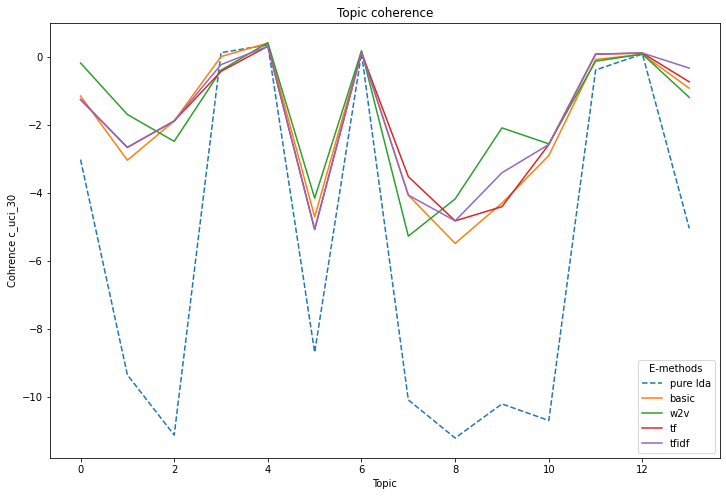

In [12]:
evaluate.draw_coherence_line(old, new_coherence, emethods, measure=measure, ws=ws)

In [13]:
ps = relation.get_phrases_by_pattern(parse)
sorted(dict(Counter([" ".join(x) for x in ps])).items(), key=lambda x:x[1], reverse=True)

func get_phrases_by_pattern exec time: 1.7445693016052246


[('latent Dirichlet allocation', 705),
 ('topic model', 646),
 ('experimental result', 431),
 ('topic modeling', 320),
 ('latent topic', 202),
 ('latent Dirichlet Allocation', 199),
 ('LDA model', 178),
 ('latent Dirichlet allocation model', 155),
 ('short text', 124),
 ('sentiment analysis', 103),
 ('social media', 99),
 ('topic distribution', 92),
 ('social network', 89),
 ('recent year', 86),
 ('Dirichlet allocation', 86),
 ('large number', 82),
 ('text mining', 80),
 ('latent Dirichlet Allocation model', 78),
 ('Gibbs sampling', 74),
 ('case study', 73),
 ('dirichlet allocation', 68),
 ('probabilistic topic model', 68),
 ('information retrieval', 65),
 ('previous work', 65),
 ('large amount', 61),
 ('natural language processing', 60),
 ('visual word', 59),
 ('latent Dirichlet allocation topic model', 57),
 ('novel approach', 57),
 ('extensive experiment', 54),
 ('better performance', 54),
 ('big datum', 53),
 ('machine learning', 52),
 ('new method', 52),
 ('online review', 51),
 (

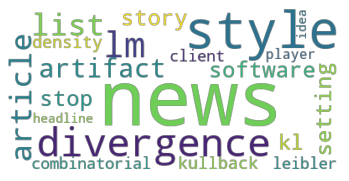

In [14]:
vis.draw_word_cloud("", {terms[k]:v for k,v in top_terms[t_idx]}, False)

In [15]:
n, o = evaluate.filter_words(extended, topic_word, vec, top_terms, top_docs, _input, terms, "tfidf")
print(n[t_idx])
print(o[t_idx])

['topic', 'news', 'word', 'player', 'use', 'model', 'list', 'idea', 'software', 'stop', 'headline', 'modeling', 'setting', 'datum', 'problem', 'report', 'gameplay', 'result', 'ths', 'article', 'artifact', 'event', 'approach', 'performance', 'style', 'propose', 'understand', 'provider', 'selection', 'focus', 'density', 'resource', 'delegate', 'apply', 'level', 'divergence', 'particular', 'way', 'probabilistic', 'specialize', 'general', 'major', 'discover', 'generation', 'feature', 'kl', 'mining', 'mixture', 'period', 'useful', 'story', 'contain', 'independent', 'discovery', 'client', 'higher', 'characteristic', 'journalist', 'embed', 'shift', 'leibler', 'kullback', 'motion', 'summarize', 'worsen', 'automatic', 'unstructured', 'appropriate', 'fact', 'core', 'criterion', 'combinatorial', 'lm']
{'artifact', 'news', 'list', 'style', 'stop', 'article', 'software'}
